In [1]:
import os

from dotenv import load_dotenv

from dynamic_pricing.db.db_utils import get_db_connection, load_order_data
import pandas as pd
import matplotlib.pyplot as plt
import itertools


load_dotenv()

True

In [2]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn, os.getenv("PARTNER1"))
print(df.info)

2024-04-14 16:50:42,689 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-04-14 16:50:42,690 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-14 16:50:42,884 INFO sqlalchemy.engine.Engine select current_schema()
2024-04-14 16:50:42,884 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-14 16:50:43,078 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-04-14 16:50:43,079 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-14 16:50:43,280 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-14 16:50:43,281 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [3]:
print(df.columns)
df.head()
df.fillna(0, inplace=True)

Index(['order_id', 'deliveroo_order_id', 'deliveroo_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'order_prepare_for_timestamp', 'order_start_prepping_at_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'deliveroo_item_id',
       'item_name', 'item_operational_name', 'item_fractional_cost',
       'item_quantity', 'item_fractional_price', 'modifier_id',
       'deliveroo_modifier_id', 'modifier_name', 'modifier_operational_name',
       'modifier_quantity', 'modifier_fractional_price'],
      dtype='object')


/tmp/ipykernel_24186/787573481.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


Filter to keep only the items we are analyzing

In [4]:
pre_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
pre_dp_df = pre_dp_df[
    (pre_dp_df["order_placed_timestamp"] >= "2023-06-26")
    & (pre_dp_df["order_placed_timestamp"] < "2023-7-17")
]
pre_dp_df.info()


post_dp_df = df[df["item_operational_name"].str.contains("Wrap")]
post_dp_df = post_dp_df[
    (post_dp_df["order_placed_timestamp"] >= "2023-7-17")
    & (post_dp_df["order_placed_timestamp"] < "2023-8-07")
]
post_dp_df.info()

interval = 30

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 0 to 234
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           64 non-null     int64         
 1   deliveroo_order_id                 64 non-null     object        
 2   deliveroo_order_number             64 non-null     int64         
 3   order_status                       64 non-null     object        
 4   order_placed_timestamp             64 non-null     datetime64[ns]
 5   order_updated_timestamp            64 non-null     datetime64[ns]
 6   order_prepare_for_timestamp        64 non-null     datetime64[ns]
 7   order_start_prepping_at_timestamp  64 non-null     datetime64[ns]
 8   customer_id                        64 non-null     int64         
 9   first_name                         64 non-null     int64         
 10  contact_number                     64 non-nu

In [5]:
from dynamic_pricing.analysis.utils import split_weekdays_and_weekends

pre_dp_df_weekdays, pre_dp_df_weekends = split_weekdays_and_weekends(
    pre_dp_df, "order_placed_timestamp"
)
post_dp_df_weekdays, post_dp_df_weekends = split_weekdays_and_weekends(
    post_dp_df, "order_placed_timestamp"
)

analysis

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "interval_index"] = (


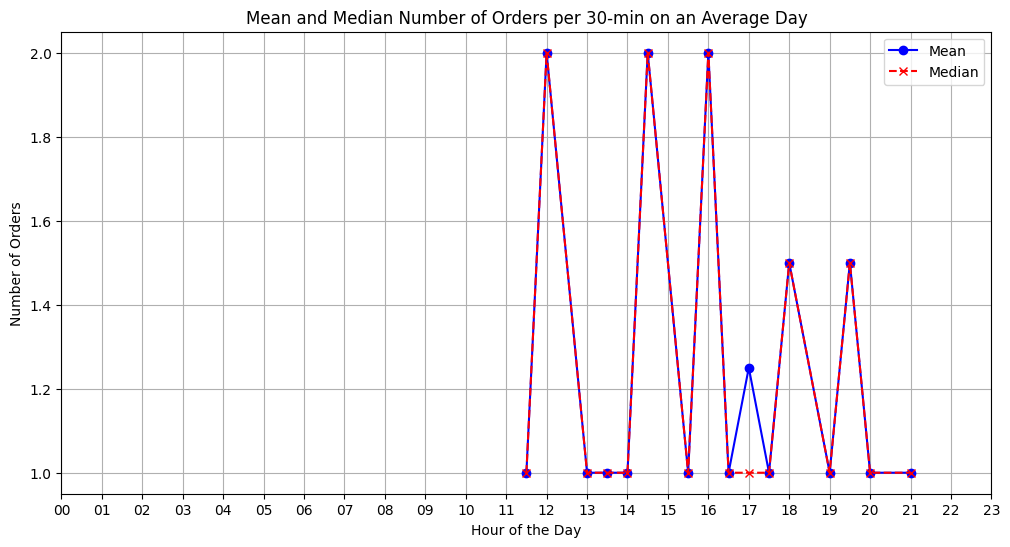

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "interval_index"] = (


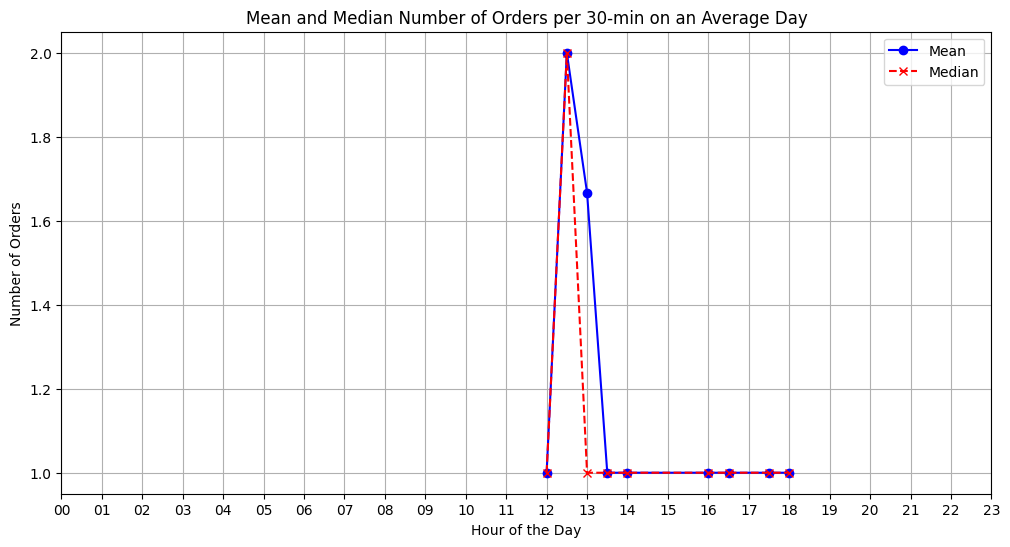

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "interval_index"] = (


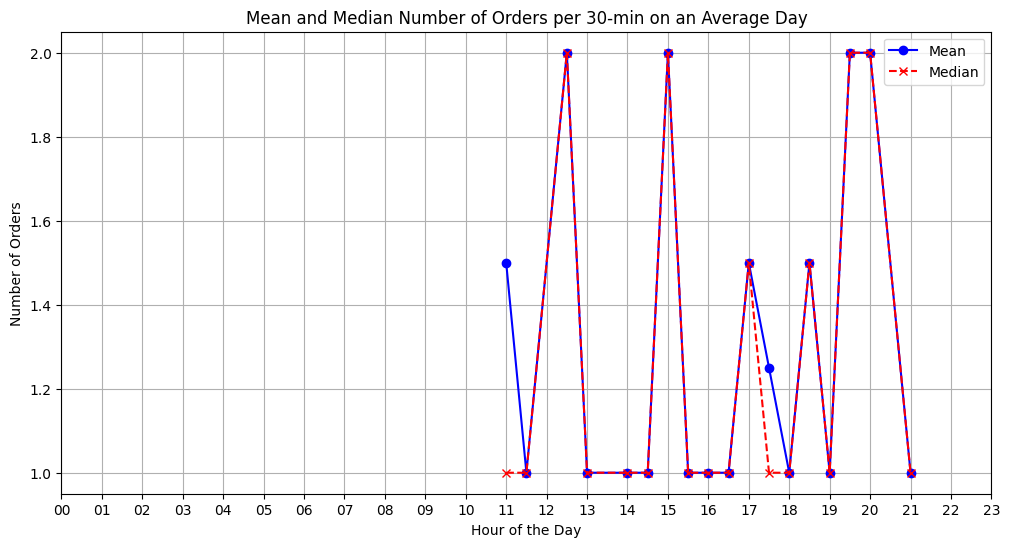

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "interval_index"] = (


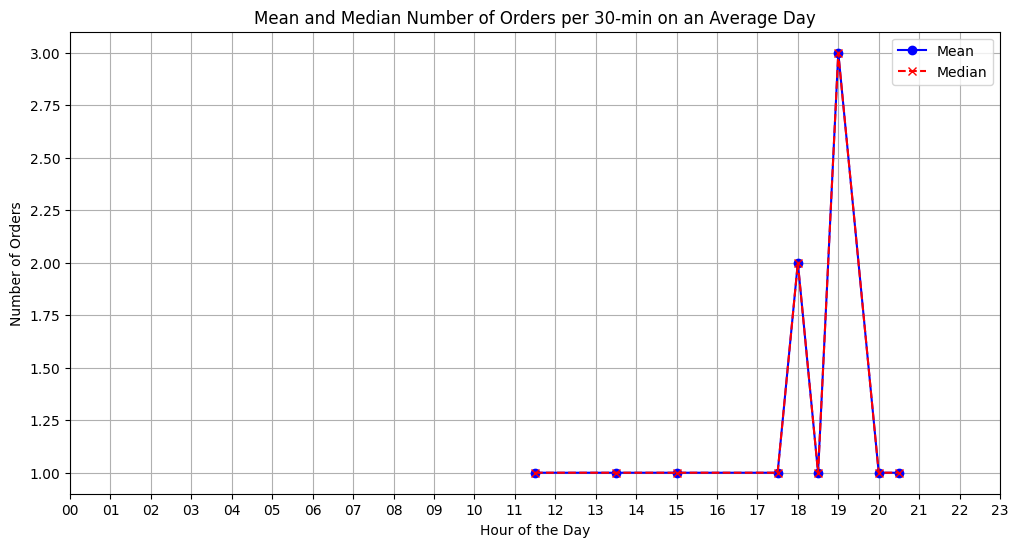

(interval_index
 23    1.0
 27    1.0
 30    1.0
 35    1.0
 36    2.0
 37    1.0
 38    3.0
 40    1.0
 41    1.0
 dtype: float64,
 interval_index
 23    1.0
 27    1.0
 30    1.0
 35    1.0
 36    2.0
 37    1.0
 38    3.0
 40    1.0
 41    1.0
 dtype: float64)

In [6]:
from dynamic_pricing.analysis.utils import calculate_average_orders_per_interval

calculate_average_orders_per_interval(pre_dp_df_weekdays, interval=interval,plot=True)
calculate_average_orders_per_interval(pre_dp_df_weekends, interval=interval, plot=True)

calculate_average_orders_per_interval(
    post_dp_df_weekdays, interval=interval, plot=True
)
calculate_average_orders_per_interval(
    post_dp_df_weekends, interval=interval, plot=True
)

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])


   order_id  item_quantity  item_fractional_price  modifier_fractional_price  \
0         2              1                    850                          0   
1         2              1                    850                          0   
2         2              1                    850                          0   
7         6              1                    970                          0   
8         8              1                    850                          0   

   modifier_quantity order_placed_timestamp  order_value  revenue  
0                  0    2023-06-26 16:04:36          8.5     25.5  
1                  0    2023-06-26 16:04:36          8.5     25.5  
2                  0    2023-06-26 16:04:36          8.5     25.5  
7                  0    2023-06-26 18:15:18          9.7      9.7  
8                  0    2023-06-26 18:23:14          8.5      8.5  


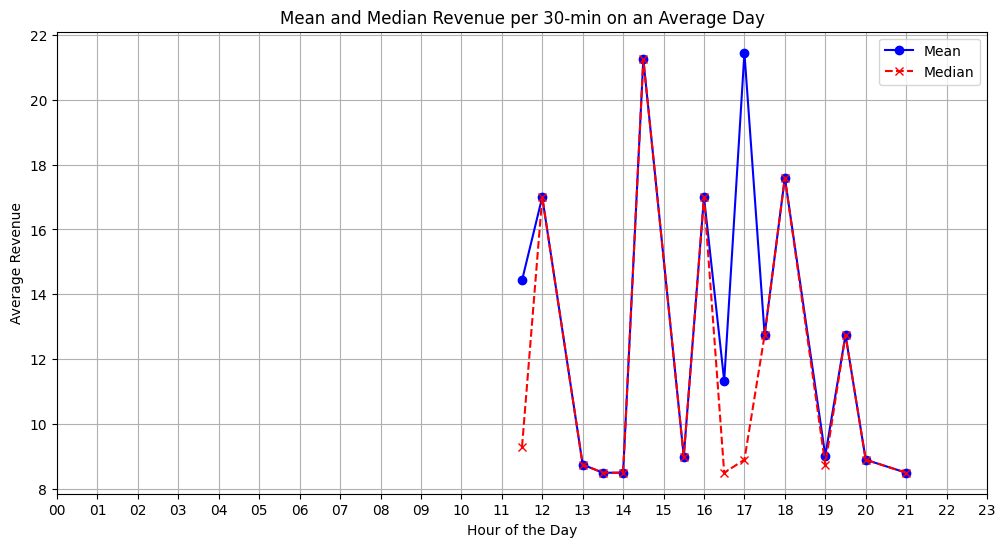

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])


    order_id  item_quantity  item_fractional_price  modifier_fractional_price  \
51        46              1                    850                          0   
58        54              1                    850                          0   
71        62              1                    850                          0   
74        64              1                    850                          0   
76        68              1                    930                          0   

    modifier_quantity order_placed_timestamp  order_value  revenue  
51                  0    2023-07-01 12:49:02          8.5      8.5  
58                  0    2023-07-01 13:15:19          8.5      8.5  
71                  0    2023-07-02 16:58:50          8.5      8.5  
74                  0    2023-07-02 17:42:12          8.5      8.5  
76                  0    2023-07-02 18:00:17          9.3      9.3  


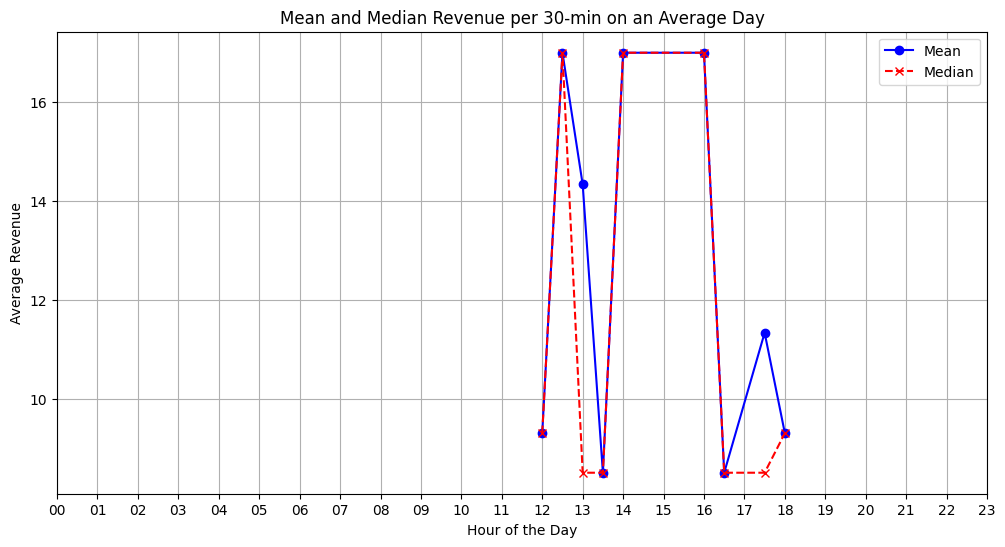

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])


     order_id  item_quantity  item_fractional_price  \
240       212              1                    850   
241       214              1                    850   
244       216              1                    850   
253       220              1                   1030   
254       222              1                    950   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
240                          0                  0    2023-07-17 14:32:32   
241                          0                  0    2023-07-17 16:06:41   
244                          0                  0    2023-07-17 16:37:34   
253                          0                  0    2023-07-18 18:06:47   
254                          0                  0    2023-07-18 19:43:39   

     order_value  revenue  
240          8.5      8.5  
241          8.5      8.5  
244          8.5      8.5  
253         10.3     10.3  
254          9.5     19.0  


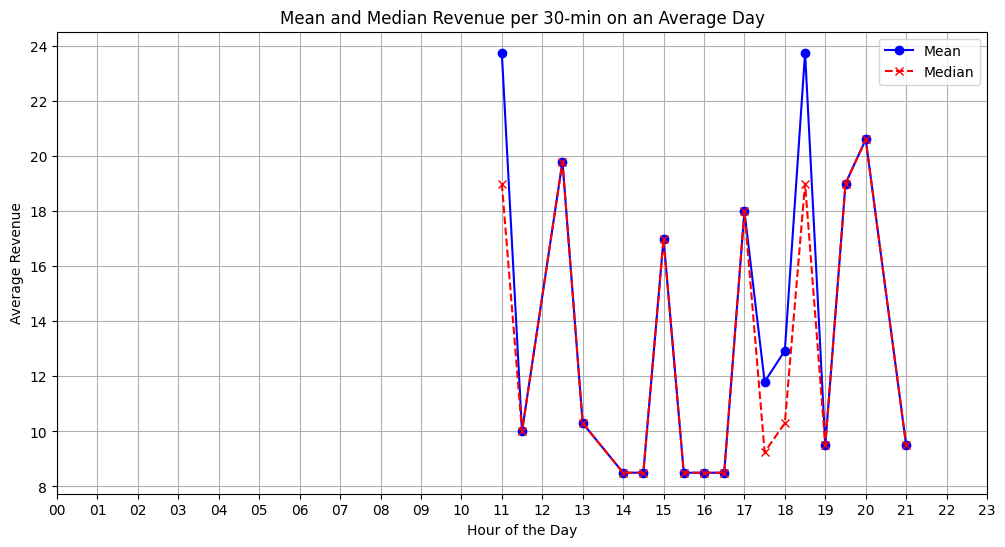

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])


     order_id  item_quantity  item_fractional_price  \
287       258              1                    850   
298       268              1                   1030   
304       274              1                    850   
305       274              1                    850   
308       278              1                    950   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
287                          0                  0    2023-07-22 13:33:43   
298                          0                  0    2023-07-22 20:36:56   
304                          0                  0    2023-07-23 18:21:03   
305                          0                  0    2023-07-23 18:21:03   
308                          0                  0    2023-07-23 20:10:38   

     order_value  revenue  
287          8.5      8.5  
298         10.3     10.3  
304          8.5     17.0  
305          8.5     17.0  
308          9.5      9.5  


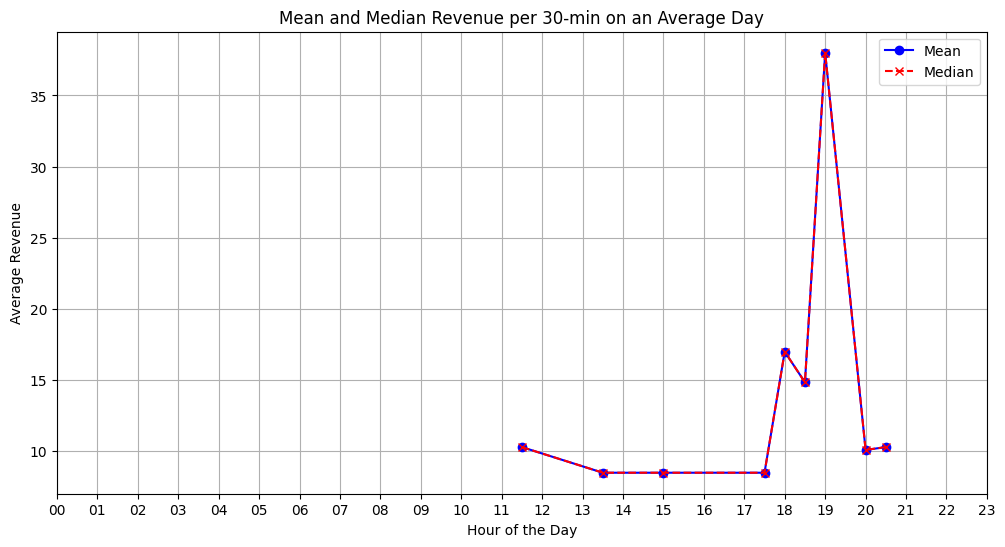

(interval_index
 23    10.30
 27     8.50
 30     8.50
 35     8.50
 36    17.00
 37    14.85
 38    38.00
 40    10.10
 41    10.30
 Name: order_value, dtype: float64,
 interval_index
 23    10.30
 27     8.50
 30     8.50
 35     8.50
 36    17.00
 37    14.85
 38    38.00
 40    10.10
 41    10.30
 Name: order_value, dtype: float64)

In [7]:
from dynamic_pricing.analysis.utils import calculate_average_revenue_per_interval

calculate_average_revenue_per_interval(pre_dp_df_weekdays, interval, plot=True)
calculate_average_revenue_per_interval(pre_dp_df_weekends, interval, plot=True)

calculate_average_revenue_per_interval(post_dp_df_weekdays, interval, plot=True)
calculate_average_revenue_per_interval(post_dp_df_weekends, interval, plot=True)

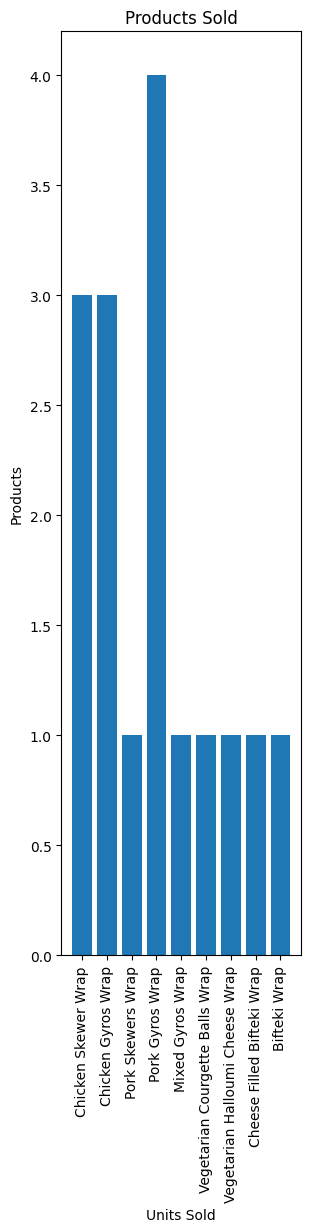

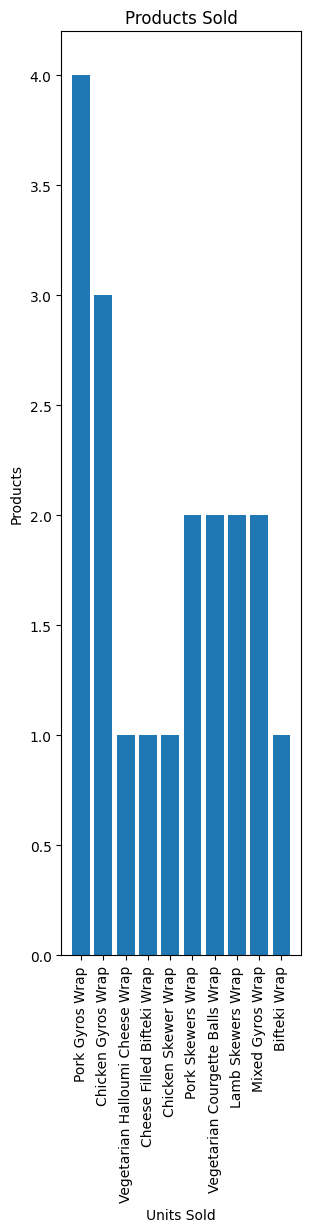

In [8]:
from dynamic_pricing.analysis.utils import plot_items_sold
plot_items_sold(pre_dp_df)
plot_items_sold(post_dp_df)

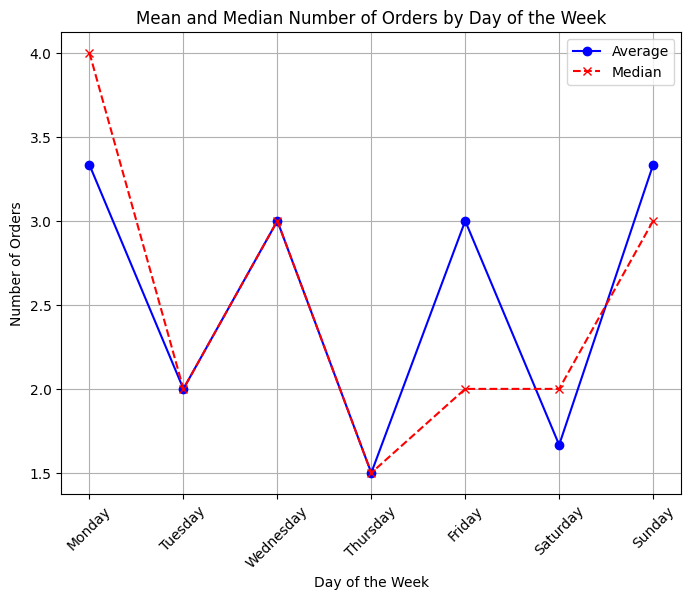

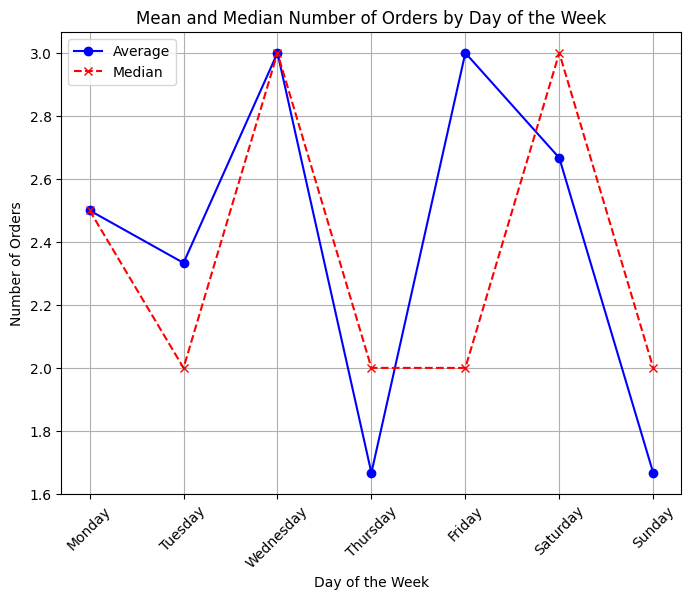

(day_of_week
 Friday       3.000000
 Monday       2.500000
 Saturday     2.666667
 Sunday       1.666667
 Thursday     1.666667
 Tuesday      2.333333
 Wednesday    3.000000
 Name: order_count, dtype: float64,
 day_of_week
 Friday       2.0
 Monday       2.5
 Saturday     3.0
 Sunday       2.0
 Thursday     2.0
 Tuesday      2.0
 Wednesday    3.0
 Name: order_count, dtype: float64)

In [9]:
from dynamic_pricing.analysis.utils import calculate_average_orders_by_day_of_week

calculate_average_orders_by_day_of_week(pre_dp_df, plot=True)
calculate_average_orders_by_day_of_week(post_dp_df, plot=True)

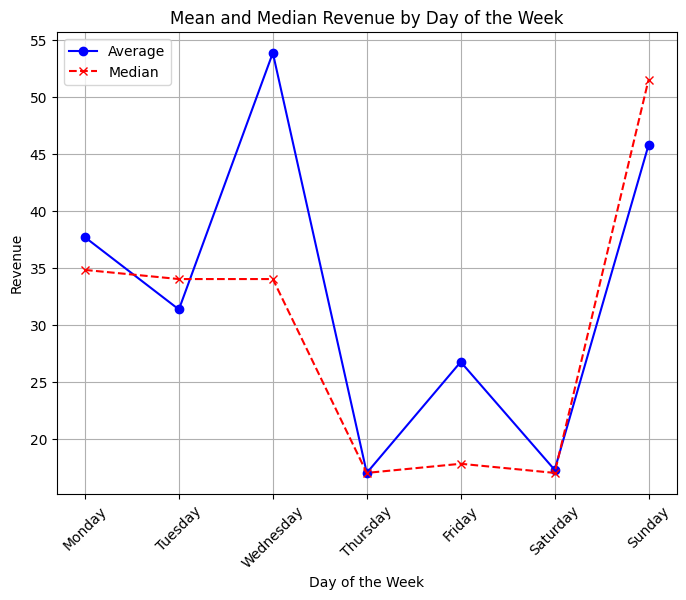

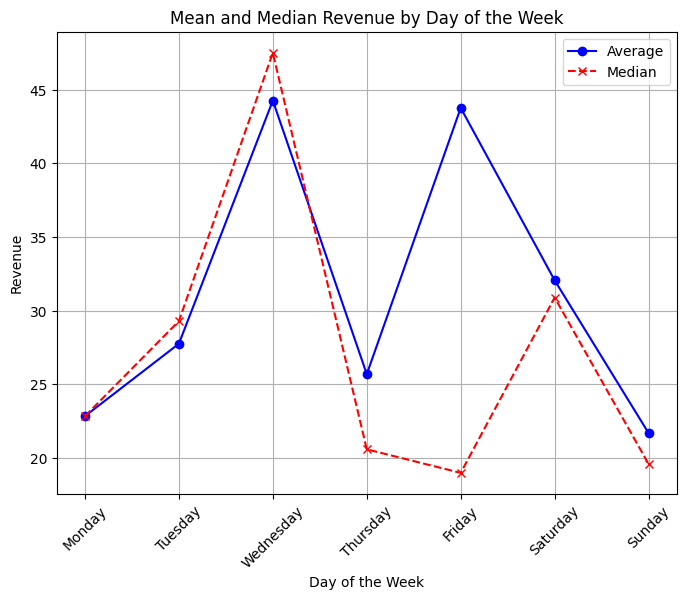

(day_of_week
 Friday       43.766667
 Monday       22.850000
 Saturday     32.066667
 Sunday       21.700000
 Thursday     25.700000
 Tuesday      27.766667
 Wednesday    44.266667
 Name: daily_revenue, dtype: float64,
 day_of_week
 Friday       19.00
 Monday       22.85
 Saturday     30.90
 Sunday       19.60
 Thursday     20.60
 Tuesday      29.30
 Wednesday    47.50
 Name: daily_revenue, dtype: float64)

In [10]:
from dynamic_pricing.analysis.utils import calculate_average_revenue_by_day_of_week

calculate_average_revenue_by_day_of_week(pre_dp_df, plot=True)
calculate_average_revenue_by_day_of_week(post_dp_df, plot=True)

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[accepted_timestamp] = pd.to_datetime(df[accepted_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:264: SettingWithCopyWarning: 
A value is tryi

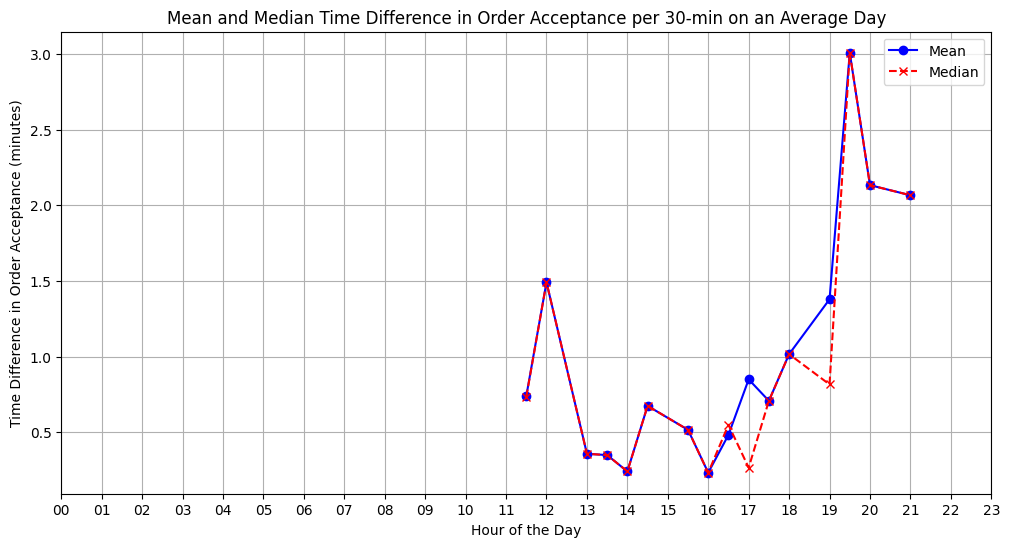

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[accepted_timestamp] = pd.to_datetime(df[accepted_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:264: SettingWithCopyWarning: 
A value is tryi

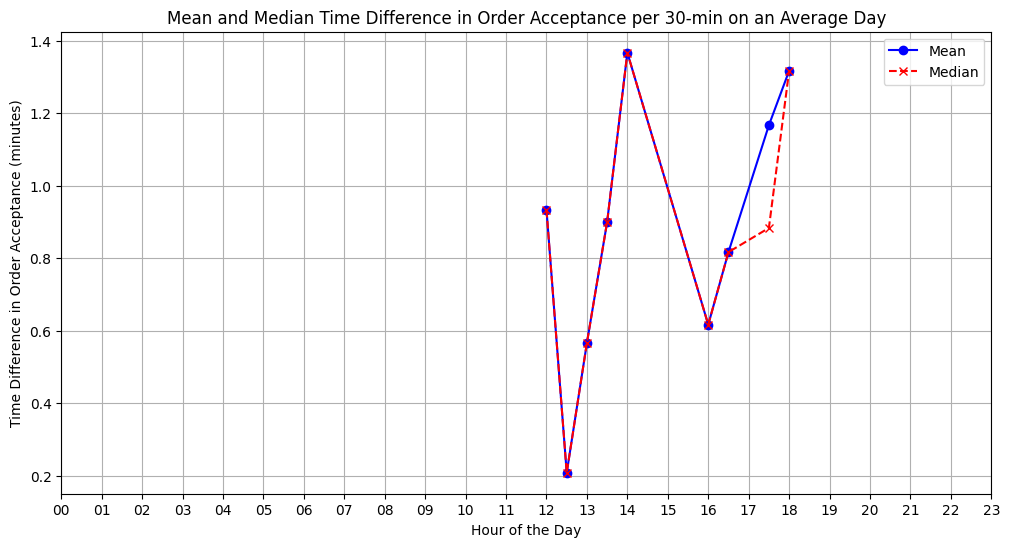

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[accepted_timestamp] = pd.to_datetime(df[accepted_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:264: SettingWithCopyWarning: 
A value is tryi

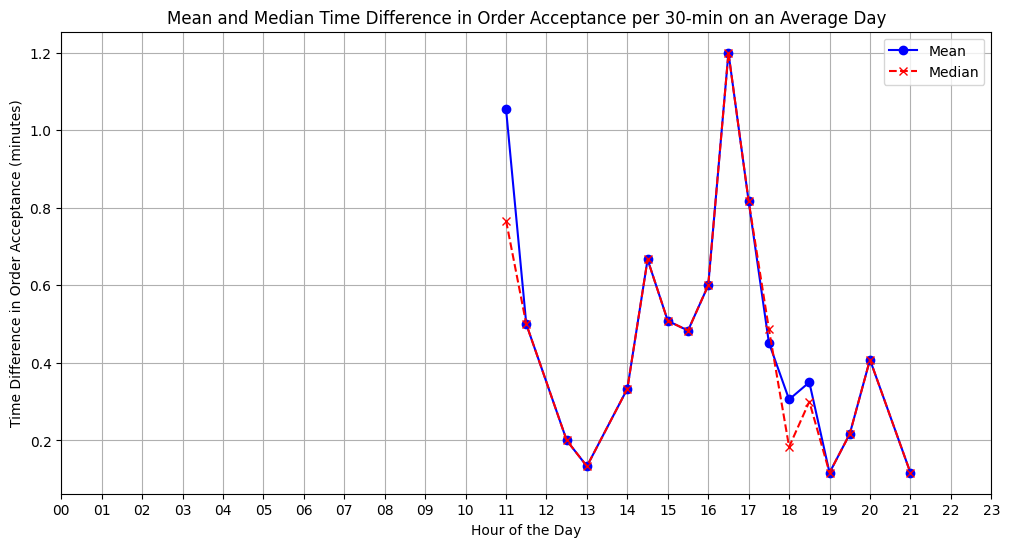

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[accepted_timestamp] = pd.to_datetime(df[accepted_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:264: SettingWithCopyWarning: 
A value is tryi

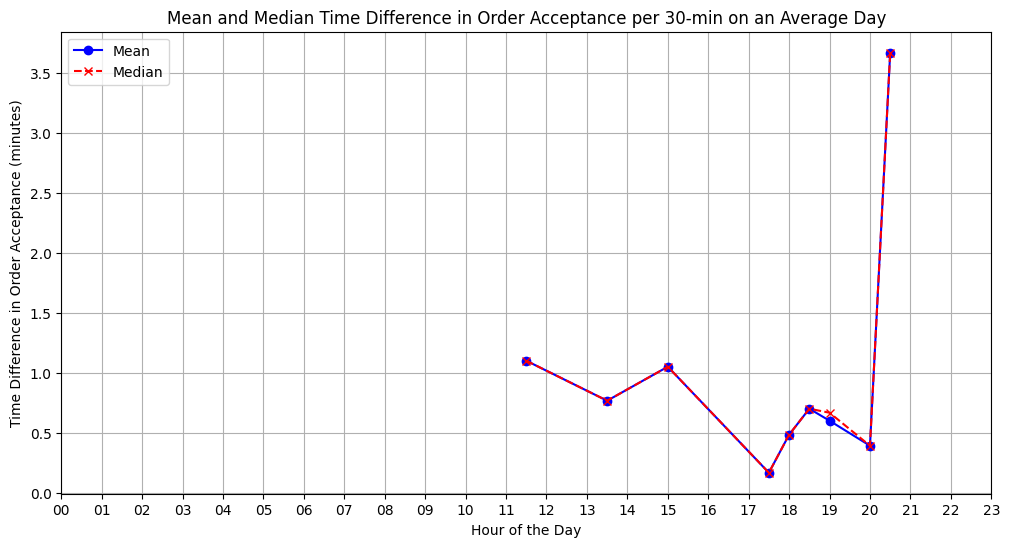

(interval_index
 23    1.100000
 27    0.766667
 30    1.050000
 35    0.166667
 36    0.483333
 37    0.700000
 38    0.600000
 40    0.391667
 41    3.666667
 Name: time_difference, dtype: float64,
 interval_index
 23    1.100000
 27    0.766667
 30    1.050000
 35    0.166667
 36    0.483333
 37    0.700000
 38    0.666667
 40    0.391667
 41    3.666667
 Name: time_difference, dtype: float64)

In [11]:
from dynamic_pricing.analysis.utils import (
    calculate_time_difference_in_order_acceptance_per_interval,
)

calculate_time_difference_in_order_acceptance_per_interval(
    pre_dp_df_weekdays, interval, plot=True
)
calculate_time_difference_in_order_acceptance_per_interval(
    pre_dp_df_weekends, interval, plot=True
)

calculate_time_difference_in_order_acceptance_per_interval(
    post_dp_df_weekdays, interval, plot=True
)
calculate_time_difference_in_order_acceptance_per_interval(
    post_dp_df_weekends, interval, plot=True
)

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_prep_time] = pd.to_datetime(df[start_prep_time])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[end_prep_time] = pd.to_datetime(df[end_prep_time])


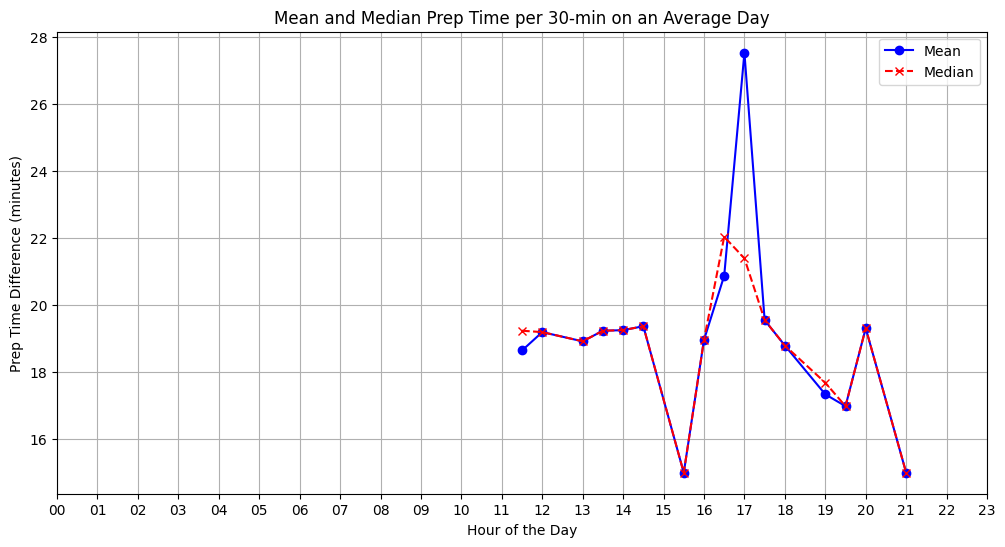

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_prep_time] = pd.to_datetime(df[start_prep_time])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[end_prep_time] = pd.to_datetime(df[end_prep_time])


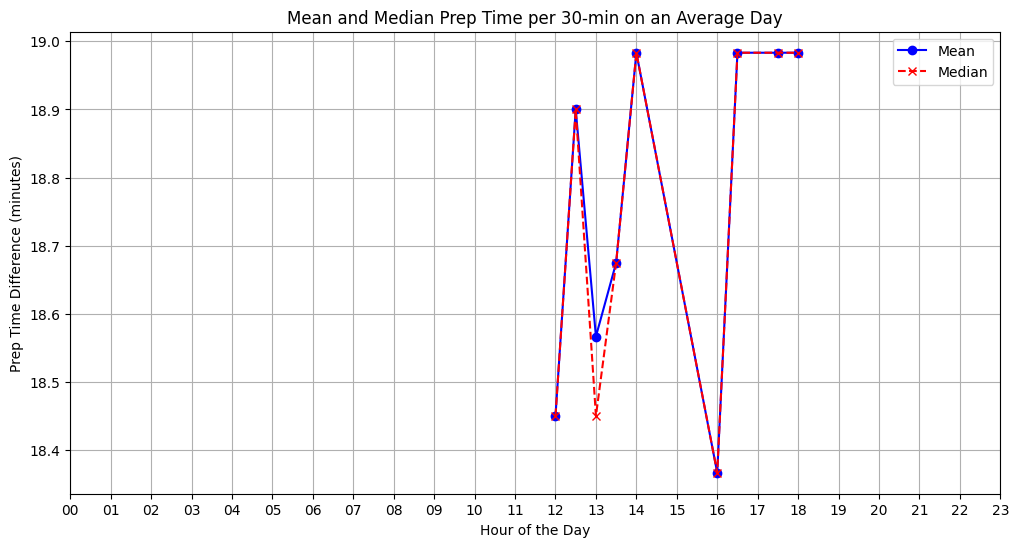

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_prep_time] = pd.to_datetime(df[start_prep_time])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[end_prep_time] = pd.to_datetime(df[end_prep_time])


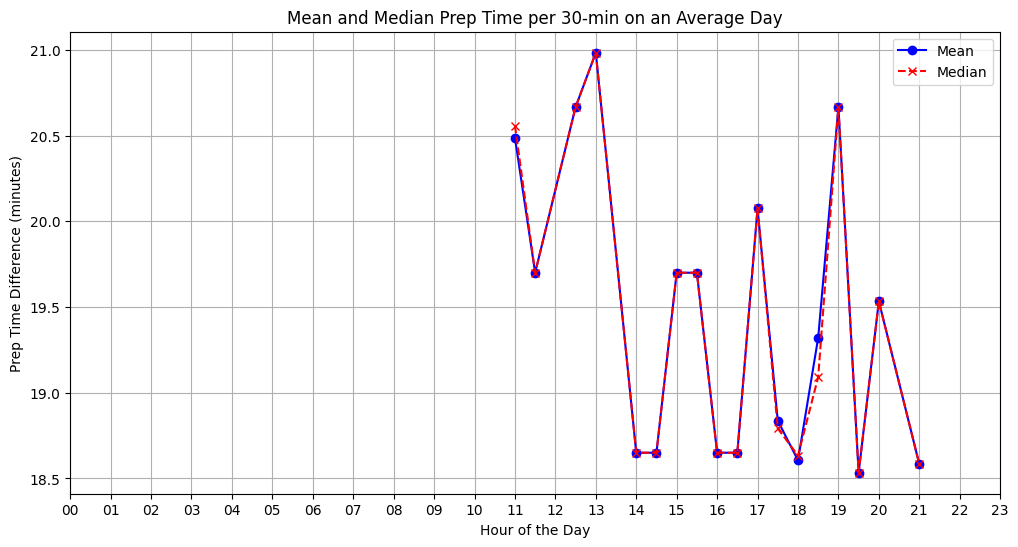

/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_prep_time] = pd.to_datetime(df[start_prep_time])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[end_prep_time] = pd.to_datetime(df[end_prep_time])


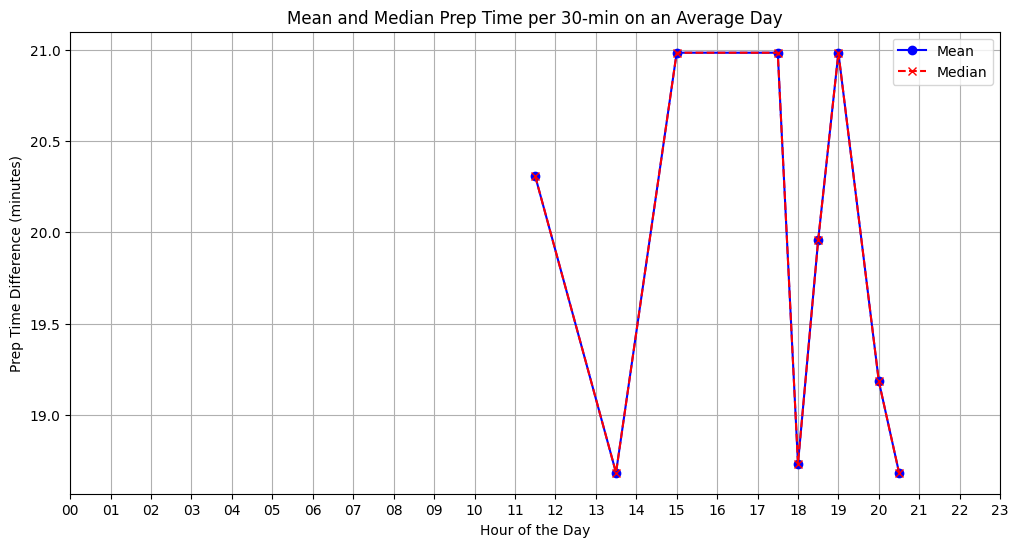

(interval_index
 23    20.308333
 27    18.683333
 30    20.983333
 35    20.983333
 36    18.733333
 37    19.958333
 38    20.983333
 40    19.183333
 41    18.683333
 Name: time_difference, dtype: float64,
 interval_index
 23    20.308333
 27    18.683333
 30    20.983333
 35    20.983333
 36    18.733333
 37    19.958333
 38    20.983333
 40    19.183333
 41    18.683333
 Name: time_difference, dtype: float64)

In [12]:
from dynamic_pricing.analysis.utils import calculate_prep_time_per_interval

calculate_prep_time_per_interval(pre_dp_df_weekdays, interval,plot=True)
calculate_prep_time_per_interval(pre_dp_df_weekends, interval, plot=True)

calculate_prep_time_per_interval(post_dp_df_weekdays, interval, plot=True)
calculate_prep_time_per_interval(post_dp_df_weekends, interval, plot=True)

Manage outliers

In [13]:
from dynamic_pricing.analysis.utils import calculate_revenue

revenue_df = calculate_revenue(pre_dp_df)
largest_series = revenue_df["revenue"].nlargest(5).reset_index(drop=True)
print(largest_series)
difference_amount = largest_series[1]-largest_series[2]
print(difference_amount)
revenue_df[revenue_df["revenue"] == largest_series[1]] #the outlier was on a wednesday at 5.26pm

0    59.5
1    59.5
2    34.0
3    34.0
4    34.0
Name: revenue, dtype: float64
25.5


,order_id,item_quantity,item_fractional_price,modifier_fractional_price,modifier_quantity,order_placed_timestamp,order_value,revenue
116,98,3,850,0,0,2023-07-05 17:26:42,25.5,59.5
118,98,4,850,0,0,2023-07-05 17:26:42,34.0,59.5


In [14]:
from dynamic_pricing.analysis.utils import calculate_revenue_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
pre_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekdays, time_intervals=time_intervals
)

pre_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekends, time_intervals=time_intervals
)
post_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

# remove outlier
pre_dp_df_weekday_revenue["14:00:00 to 18:45:00"] = pre_dp_df_weekday_revenue[
    "14:00:00 to 18:45:00"
] - difference_amount

print(pre_dp_df_weekday_revenue, pre_dp_df_weekday_revenue.sum())
print(pre_dp_df_weekend_revenue, pre_dp_df_weekend_revenue.sum())
print(post_dp_df_weekday_revenue, post_dp_df_weekday_revenue.sum())
print(post_dp_df_weekend_revenue, post_dp_df_weekend_revenue.sum())

interval_label
00:00:00 to 14:00:00    111.8
14:00:00 to 18:45:00    257.5
18:45:00 to 23:59:59     87.9
Name: order_value, dtype: float64 457.20000000000005
interval_label
00:00:00 to 14:00:00    103.3
14:00:00 to 18:45:00     85.8
Name: order_value, dtype: float64 189.1
interval_label
00:00:00 to 14:00:00    135.1
14:00:00 to 18:45:00    248.0
18:45:00 to 23:59:59     87.1
Name: order_value, dtype: float64 470.20000000000005
interval_label
00:00:00 to 14:00:00    29.1
14:00:00 to 18:45:00    34.0
18:45:00 to 23:59:59    98.2
Name: order_value, dtype: float64 161.3


/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "order_value"] = (
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [15]:
from dynamic_pricing.analysis.utils import calculate_profit_by_day_period

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
pre_dp_df_weekday_profit= calculate_profit_by_day_period(
    pre_dp_df_weekdays, time_intervals=time_intervals
)

pre_dp_df_weekend_profit = calculate_profit_by_day_period(
    pre_dp_df_weekends, time_intervals=time_intervals
)
post_dp_df_weekday_profit = calculate_profit_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_profit = calculate_profit_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

# remove outlier
pre_dp_df_weekday_profit.loc["14:00:00 to 18:45:00"] -= difference_amount

print(pre_dp_df_weekday_profit, pre_dp_df_weekday_profit.sum())
print(pre_dp_df_weekend_profit, pre_dp_df_weekend_profit.sum())
print(post_dp_df_weekday_profit, post_dp_df_weekday_profit.sum())
print(post_dp_df_weekend_profit, post_dp_df_weekend_profit.sum())

interval_label
00:00:00 to 14:00:00     89.8
14:00:00 to 18:45:00    209.5
18:45:00 to 23:59:59     67.9
Name: profit, dtype: float64 367.20000000000005
interval_label
00:00:00 to 14:00:00    79.3
14:00:00 to 18:45:00    71.8
Name: profit, dtype: float64 151.1
interval_label
00:00:00 to 14:00:00    115.1
14:00:00 to 18:45:00    203.5
18:45:00 to 23:59:59     71.1
Name: profit, dtype: float64 389.70000000000005
interval_label
00:00:00 to 14:00:00    23.1
14:00:00 to 18:45:00    26.0
18:45:00 to 23:59:59    82.2
Name: profit, dtype: float64 131.3


/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[order_timestamp] = pd.to_datetime(df[order_timestamp])
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "profit"] = df["order_value"] - (
/home/sree/Desktop/UCL/FYP/dynamic_pricing/src/dynamic_pricing/analysis/utils.py:456: SettingWithCopyWarning: 
A value is trying to be set on a co

checkout any major events 
look at seasionality of the month